<div style="background: linear-gradient(to right, #6a11cb, #2575fc); padding: 20px; border-radius: 10px; text-align: center; box-shadow: 0 4px 6px rgba(0,0,0,0.1);">
    <h1 style="color: white; margin: 0; font-size: 2.5em; font-weight: 700;">GAICo: Evaluating Structured Outputs</h1>
    <p style="color: #e0e0e0; margin-top: 10px; font-style: italic; font-size: 1.2em; text-align: center;">Why Specialized Metrics Matter: A Comparison</p>
</div>
<br>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ai4society/GenAIResultsComparator/blob/main/examples/example-structured_data.ipynb)

This notebook demonstrates how to use **GAICo's** specialized metrics for evaluating structured outputs and highlights why they are often more suitable than standard text-based metrics for these tasks. We will focus on two domains: **automated planning** and **time-series analysis**.

The goal is to show a side-by-side comparison:

1.  **Planning Sequence Comparison:**
    - We'll evaluate LLM-generated action plans using specialized metrics (`PlanningLCS`, `PlanningJaccard`) and standard text metrics (`Jaccard`, `Levenshtein`).
    - We will see how structured metrics correctly interpret sequence order and action sets, while text metrics can be misleading.

2.  **Time-Series Data Comparison:**
    - We'll evaluate LLM-generated time-series data using `TimeSeriesElementDiff` (for key-value accuracy), `TimeSeriesDTW` (for shape similarity), and standard text metrics.
    - This will illustrate how structured metrics can parse numeric values and sequence shapes, providing a much more meaningful evaluation than simple string comparison.

### Setup for Google Colab

If you are running this notebook in Google Colab, uncomment and run the following cell to install the `gaico` package.

If you are running locally, you can skip this cell if you have already set up your environment according to the project's README.


In [ ]:
# !pip install gaico -q

### Environment Setup & Imports

The cell below adjusts `sys.path` to find the gaico module if run from examples directory.

This block is primarily for local execution from the `examples/` folder if gaico is not installed.


In [1]:
import os
import sys

# Adjust sys.path to find the gaico module if run from examples directory
notebook_dir = os.getcwd()  # Get the current working directory of the notebook
# Construct the path to the project root (one level up)
project_root = os.path.abspath(os.path.join(notebook_dir, os.pardir))

# Add project root to the system path if it's not already there
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    print(f"Added project root to sys.path: {project_root}")

In [2]:
import pandas as pd

# Import the Experiment class for streamlined comparison
from gaico import Experiment

# Import a specific metric class to show direct instantiation
from gaico.metrics.structured import TimeSeriesElementDiff

---

## Part 1: Planning Sequence Metrics
In this section, we'll evaluate LLM-generated action plans. An ideal plan should contain the correct actions in the correct order.

We will compare two types of metrics:

- **Structured Metrics:**
  - **`PlanningLCS` (Longest Common Subsequence):** Sensitive to the order of actions.
  - **`PlanningJaccard`:** Treats plans as sets of actions, ignoring order.
- **Standard Text Metrics:**
  - **`Jaccard` & `Levenshtein`:** Treat the plans as simple strings.

Let's see which metrics provide more useful insights.

In [3]:
# 1. Define the planning data
# The reference plan includes a set of concurrent actions {action_2a, action_2b}
reference_plan = "action_1, {action_2a, action_2b}, action_3"

llm_plans = {
    "PerfectModel": "action_1, {action_2a, action_2b}, action_3",  # Identical to reference
    "ReorderedModel": "action_3, action_1, {action_2b, action_2a}",  # Correct actions, wrong order
    "IncompleteModel": "action_1, action_3",  # Missing the concurrent actions
    "ExtraActionModel": "action_1, {action_2a, action_2b}, action_4, action_3",  # Has an extra action
}

print("Reference Plan:", reference_plan)
print("\nLLM-Generated Plans:")

for model, plan in llm_plans.items():
    print(f"- {model}: {plan}")

Reference Plan: action_1, {action_2a, action_2b}, action_3

LLM-Generated Plans:
- PerfectModel: action_1, {action_2a, action_2b}, action_3
- ReorderedModel: action_3, action_1, {action_2b, action_2a}
- IncompleteModel: action_1, action_3
- ExtraActionModel: action_1, {action_2a, action_2b}, action_4, action_3


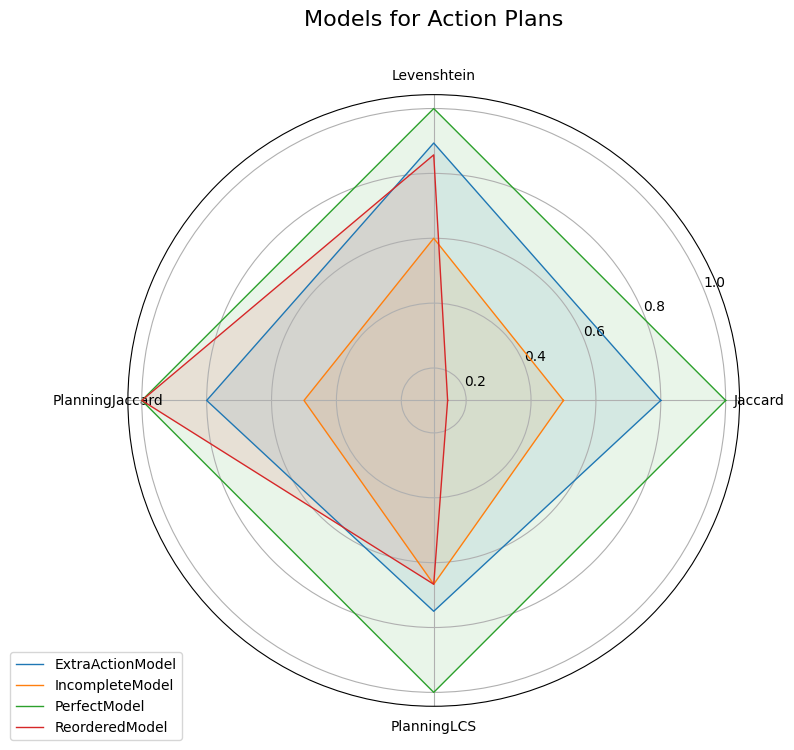

CSV report generated at: data/structured_examples/planning_metrics_report.csv

DataFrame of Planning Metric Scores:
metric_name       Jaccard  Levenshtein  PlanningJaccard  PlanningLCS
model_name                                                          
ExtraActionModel   0.8000       0.8936              0.8       0.7500
IncompleteModel    0.5000       0.6000              0.5       0.6667
PerfectModel       1.0000       1.0000              1.0       1.0000
ReorderedModel     0.1429       0.8571              1.0       0.6667


In [4]:
# 2. Initialize and run the Experiment
planning_exp = Experiment(llm_responses=llm_plans, reference_answer=reference_plan)

# Ensure output directory exists
output_dir_planning = os.path.join("data", "structured_examples")
os.makedirs(output_dir_planning, exist_ok=True)
csv_path_planning = os.path.join(output_dir_planning, "planning_metrics_report.csv")

# 3. Compare using both structured and standard text metrics
# We include 'Jaccard' and 'Levenshtein' to see how they perform on structured text.
planning_results_df = planning_exp.compare(
    metrics=["PlanningLCS", "PlanningJaccard", "Jaccard", "Levenshtein"],
    plot=True,
    output_csv_path=csv_path_planning,
    plot_title_suffix="for Action Plans",
)

print("\nDataFrame of Planning Metric Scores:")
# Displaying with higher precision for clarity
with pd.option_context("display.precision", 4):
    print(planning_results_df.pivot(index="model_name", columns="metric_name", values="score"))

### Analysis of Planning Results: Structured vs. Text Metrics

The radar plot and the DataFrame clearly show the limitations of standard text metrics for this task. Let's focus on the `ReorderedModel`:

- **`ReorderedModel` Analysis:**
  - **`PlanningJaccard` (`1.0`):** Correctly identifies that the model produced the right *set* of actions, giving it a perfect score. This is useful for checking completeness.
  - **`PlanningLCS` (`0.67`):** Correctly penalizes the model for getting the order wrong. This is crucial for sequential tasks.
  - **`Jaccard` (Text) (`0.14`):** This score is low and misleading. It simply tokenizes the string by spaces (`"action_1,"`, `"{action_2a,"`, etc.) and finds a low overlap because the order of tokens is different. It fails to understand that `{action_2a, action_2b}` is the same as `{action_2b, action_2a}`.
  - **`Levenshtein` (`0.86`):** While high, this score is also not very informative. It measures character-level edits, which doesn't capture the semantic meaning of reordering entire actions.

**Conclusion:** The structured metrics (`PlanningLCS`, `PlanningJaccard`) provide a much more accurate and interpretable evaluation because they understand the underlying structure of the action plan.

---

## Part 2: Time-Series Data Metrics

Now, let's evaluate LLM-generated time-series data. Simple text comparison is often ineffective here because it can't parse numbers or understand the "shape" of the data.

We will compare:

- **Structured Metrics:**
  - **`TimeSeriesElementDiff`:** Evaluates the accuracy of both keys (time points) and their corresponding numeric values.
  - **`TimeSeriesDTW` (Dynamic Time Warping):** Ignores keys and compares the *shape* of the value sequences. This is useful for checking if the trend is correct, even if the values are slightly off or out of phase.
- **Standard Text Metrics:**
  - **`Jaccard` & `Levenshtein`:** Treat the time-series as simple strings.

In [5]:
# 1. Define the time-series data
reference_ts = "t1: 70, t2: 72, t3: 75"

llm_forecasts = {
    "PerfectModel": "t1: 70, t2: 72, t3: 75",  # Identical
    "GoodValueModel": "t1: 71, t2: 73, t3: 76",  # All keys match, values are close
    "MissingPointModel": "t1: 70, t3: 75",  # Missing the t2 data point
    "WrongKeyModel": "t1: 70, t2: 72, t4: 80",  # Has t4 instead of t3
}

print("Reference Time-Series:", reference_ts)
print("\nLLM-Generated Forecasts:")
for model, forecast in llm_forecasts.items():
    print(f"- {model}: {forecast}")

Reference Time-Series: t1: 70, t2: 72, t3: 75

LLM-Generated Forecasts:
- PerfectModel: t1: 70, t2: 72, t3: 75
- GoodValueModel: t1: 71, t2: 73, t3: 76
- MissingPointModel: t1: 70, t3: 75
- WrongKeyModel: t1: 70, t2: 72, t4: 80


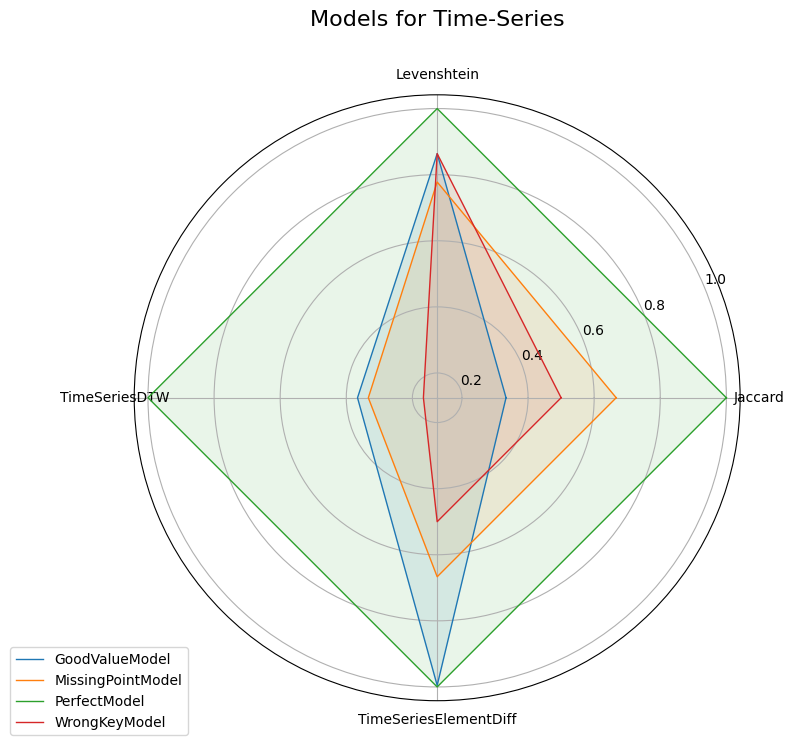

CSV report generated at: data/structured_examples/timeseries_metrics_report.csv

DataFrame of Time-Series Metric Scores:
metric_name        Jaccard  Levenshtein  TimeSeriesDTW  TimeSeriesElementDiff
model_name                                                                   
GoodValueModel      0.3333       0.8636         0.3660                 0.9954
MissingPointModel   0.6667       0.7778         0.3333                 0.6667
PerfectModel        1.0000       1.0000         1.0000                 1.0000
WrongKeyModel       0.5000       0.8636         0.1667                 0.5000


In [6]:
# 2. Initialize and run the Experiment
ts_exp = Experiment(llm_responses=llm_forecasts, reference_answer=reference_ts)

# Ensure output directory exists
output_dir_ts = os.path.join("data", "structured_examples")
os.makedirs(output_dir_ts, exist_ok=True)
csv_path_ts = os.path.join(output_dir_ts, "timeseries_metrics_report.csv")

# 3. Compare using structured and standard text metrics
# We add TimeSeriesDTW to evaluate shape, and Jaccard/Levenshtein for comparison.
ts_results_df = ts_exp.compare(
    metrics=["TimeSeriesElementDiff", "TimeSeriesDTW", "Jaccard", "Levenshtein"],
    plot=True,
    output_csv_path=csv_path_ts,
    plot_title_suffix="for Time-Series",
)

print("\nDataFrame of Time-Series Metric Scores:")
# Displaying with higher precision for clarity
with pd.option_context("display.precision", 4):
    print(ts_results_df.pivot(index="model_name", columns="metric_name", values="score"))

### Analysis of Time-Series Results: Structured vs. Text Metrics

The results for time-series data are even more stark. Let's analyze the `GoodValueModel`, which has the right keys but slightly wrong values.

- **`GoodValueModel` Analysis:**
  - **`TimeSeriesElementDiff` (`0.9954`):** This metric provides the most intuitive score. It correctly parses the keys and values, recognizes that all keys match, and finds that the numeric values are very close to the reference, resulting in a near-perfect score.
  - **`TimeSeriesDTW` (`0.3660`):** This score is surprisingly low. The metric compares the value sequences `[70, 72, 75]` and `[71, 73, 74]`. While the *shape* is identical (a rising trend), the default similarity `1/(1+d)` is based on the absolute DTW distance (~1.73). This distance isn't normalized by the scale of the data, so the score is low. This highlights that `TimeSeriesElementDiff` is better for assessing value accuracy, while `TimeSeriesDTW` is more focused on shape alignment (and may require different normalization for some use cases).
  - **`Jaccard` (Text) (`0.3333`):** The score is low and misleading. It's not zero because the keys (`t1:`, `t2:`, `t3:`) are common tokens. However, it treats the numeric values (`"70,"`, `"71,"`) as completely different words, failing to capture their proximity.
  - **`Levenshtein` (`0.8636`):** The score is high, but only because the strings are coincidentally similar at a character level. For the `WrongKeyModel`, it also gives a high score (`0.8636`), failing to penalize the incorrect key (`t4`) more severely than the slightly incorrect values in `GoodValueModel`.

**Conclusion:** For time-series data, text-based metrics are highly unreliable. Structured metrics are essential. `TimeSeriesElementDiff` excels at evaluating key-value accuracy, while `TimeSeriesDTW` evaluates sequence shape, providing complementary insights into the data's quality.

### Customizing Time-Series Metric Weights

The `Experiment` class uses the default initialization for metrics. To use custom parameters, like changing the `key_to_value_weight_ratio` in `TimeSeriesElementDiff`, you can instantiate the metric class directly.

Let's see how changing the weight affects the score for the `GoodValueModel`. We will compare the default ratio (2:1) with a much higher ratio (10:1), which should place more importance on matching keys and less on value accuracy.


In [7]:
# Instantiate metrics with different weights
ts_metric_default_weight = TimeSeriesElementDiff()  # Default key_to_value_weight_ratio = 2.0
ts_metric_high_key_weight = TimeSeriesElementDiff(key_to_value_weight_ratio=10.0)

# The data for the model we are testing
generated_ts = llm_forecasts["GoodValueModel"]

# Calculate scores with both metric instances
score_default = ts_metric_default_weight.calculate(generated_ts, reference_ts)
score_high_weight = ts_metric_high_key_weight.calculate(generated_ts, reference_ts)

print(f"Score for 'GoodValueModel' with default key:value weight (2:1): {score_default:.4f}")
print(f"Score for 'GoodValueModel' with high key:value weight (10:1):   {score_high_weight:.4f}")

Score for 'GoodValueModel' with default key:value weight (2:1): 0.9954
Score for 'GoodValueModel' with high key:value weight (10:1):   0.9987


As you can see, when we increase the weight of matching keys relative to values, the score for `GoodValueModel` increases. This is because the penalty for its slightly inaccurate values becomes less significant compared to the reward for correctly identifying all the time points. This customizability allows you to tailor the evaluation to what matters most for your specific application.

### Conclusion

This notebook has demonstrated how to leverage GAICo's specialized metrics for structured data. By choosing the right metric—or even customizing its parameters—you can gain deeper, more meaningful insights into the performance of LLMs on tasks that go beyond simple text generation.
